In [1]:
import drag_functions_turb as fn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from time_TvsR import *
from matplotlib.ticker import MultipleLocator
import scipy.optimize as opt
from matplotlib.colors import LogNorm
from cycler import cycler
from PebAcc_Turb import *
from matplotlib import cm

%matplotlib inline

colors = ['#4D4D4D','#5DA5DA', '#FAA43A', '#60BD68', '#F17CB0','#B2912F','#B276B2','#DECF3F','#F15854']
          # (black), (blue), (orange), (green), (pink), (brown), (purple), (yellow), (red)
mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

In [2]:
def d_V_12(t_1=1.,t_2=1.,t_L=1,Re=1e8):
    """Function for reproducing Eqn. (16) in OC07. Might need to add more input parameters"""
    t_eta = Re**(-0.5)*t_L
    if (t_1 <= t_eta) and (t_2 <= t_eta):
        return np.sqrt(t_L / t_eta * (t_1 - t_2)**2)
    elif (t_1 > t_eta) and (t_1 < t_L):
        y_a = 1.6
        eps = t_1 / t_2
        #print("This is the intermediate regime. Don't use it!")
        return np.sqrt(2 * y_a - (1 + eps) + 2/(1 + eps) * (1/(1 + y_a) + eps**3/(y_a + eps))) * np.sqrt(t_1)
    elif (t_1 >= t_L):
        return np.sqrt(1/(1 + t_1) + 1/(1 + t_2))
    else:
        print("Something's broken. Probably an issue with St_core.", t_1, t_eta)#, t_eta, t_1, t_2)
        return np.sqrt(1/(1 + t_1) + 1/(1 + t_2))

In [3]:
def y_str_eqn(y_str,st):
    """Equation 21d from OC07 with term on RHS subtracted over. Ignores V_0 term following text,
    which we may want to include later."""
    return 2./3. * y_str * (y_str - 1.)**2. - (1 + y_str)**(-1.) + (1 + st**(-1.))**(-1.)

def st_str(st):
    """Function to solve for t_* following OC07 21d. Ignores V_0 term. """
    if st>=1:
        return 1. #Don't allow t_* > t_L
    else:
        return opt.fsolve(y_str_eqn,st,args=(st))[0]*st
    
def d_V_12(t_1=1.,t_2=1.,t_L=1,Re=1e8):
    """Function for reproducing Eqn. (16) in OC07. Might need to add more input parameters"""
    
    t_eta = Re**(-0.5)*t_L
    
    t_1_str = st_str(t_1)
    t_2_str = st_str(t_2)
    t_12_str = max(t_1_str,t_2_str)
    t_12_str = max(t_12_str,t_eta)

    term_1 = (t_12_str + t_1**2./(t_1 + t_12_str) - (t_eta + t_1**2./(t_1 + t_eta))) +\
                ( (t_2 - t_1)/(t_1 + t_2) * (t_1**2./(t_1 + t_L) - t_1**2./(t_1 + t_12_str)) )

    term_2 = (t_12_str + t_2**2./(t_2 + t_12_str) - (t_eta + t_2**2./(t_2 + t_eta))) +\
                ( (t_1 - t_2)/(t_2 + t_1) * (t_2**2./(t_2 + t_L) - t_2**2./(t_2 + t_12_str)) )

    return np.sqrt(term_1 + term_2)

In [4]:
# Now, replace the functions above w/ purely functional versions (get rid of debugging stuff)
boltzmann = 1.380658e-16 #cgs
mH = 1.6733000e-24 #grams
G = 6.67259e-8 #cgs
SB = 5.6704e-5
Ldot = 3.839e33
rsun = 7e10

def y_str_eqn(y_str,st):
    """Equation 21d from OC07 with term on RHS subtracted over. Ignores V_0 term following text,
    which we may want to include later."""
    return 2./3. * y_str * (y_str - 1.)**2. - (1 + y_str)**(-1.) + (1 + st**(-1.))**(-1.)

def st_str(st):
    """Function to solve for t_* following OC07 21d. Ignores V_0 term. """
    if st>=1:
        return 1. #Don't allow t_* > t_L
    else:
        return opt.fsolve(y_str_eqn,st,args=(st)) [0]*st
    
def d_V_12(t_1=1.,t_2=1.,t_L=1,Re=1e8):
    """Function for reproducing Eqn. (16) in OC07. Might need to add more input parameters"""
    t_eta = Re**(-0.5)*t_L
    t_1_str = st_str(t_1)
    t_2_str = st_str(t_2)
    t_12_str = max(t_1_str,t_2_str)
    t_12_str = max(t_12_str,t_eta)

    term_1 = (t_12_str + t_1**2./(t_1 + t_12_str) - (t_eta + t_1**2./(t_1 + t_eta))) +\
                ( (t_2 - t_1)/(t_1 + t_2) * (t_1**2./(t_1 + t_L) - t_1**2./(t_1 + t_12_str)) )

    term_2 = (t_12_str + t_2**2./(t_2 + t_12_str) - (t_eta + t_2**2./(t_2 + t_eta))) +\
                ( (t_1 - t_2)/(t_2 + t_1) * (t_2**2./(t_2 + t_L) - t_2**2./(t_2 + t_12_str)) )

    return np.sqrt(term_1 + term_2)

def t_grow(s, a, f_d, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
    
    T = T_0 * (a**(-3/7))
    c_s = np.sqrt((boltzmann * T)/(2.35*mH))
    Om = np.sqrt((fn.G * m_star * fn.m_sun)/(a * fn.au)**3.)
    v_kep = Om *(a * fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    H  = c_s/ Om
    r_c = r_crit
    gamma = 1
    sigma = sigma_0 * ((a/r_c)**(-gamma))*np.exp(-(a/r_c)**(2-gamma))
    
    M = 1 # Assumed that M_core = 1 earth mass
    st = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=M,sig_in=sigma,temp_in=T)
    m = 4/3 * np.pi * rho_int * s**3
    rho = 1e-2 * sigma/H #f_d * sigma/H
    sig = np.pi * s**2
    v0 = eta*v_kep
    vgas = np.sqrt(v0**2 + alpha*c_s**2.)
    rhoGas = fn.gas_density(sigma, H)
    lambda_mfp = fn.mean_free_path(fn.mu,rhoGas,fn.cross) #1./((rhoGas/(2.3*mH))*10.**(-15.))
    nu = lambda_mfp*c_s
    Re = fn.rey(s, v0, fn.therm_vel(c_s), lambda_mfp) #(alpha*c_s**2)/(nu*Om)
    v = v0 * d_V_12(t_1=st, t_2=0.5*st, t_L=1)
    
    return m/(rho * sig * v) # This is actually the last doubling time. Should I add some prefactor?

def dust_to_gas(disk_age, a, params):    
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
    
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    time_grow = disk_age
    r_c = r_crit
    gamma = 1
    sigma = sigma_0 * ((a/r_c)**(-gamma))*np.exp(-(a/r_c)**(2-gamma))
        
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    H = c_s/Om
    rhoGas = fn.gas_density(sigma, H)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    v0 = eta*v_kep
    
    St_max = (a*fn.au)/(2 * v0 * time_grow)
    # Assumed that M_core = 1 earth mass
    s_max = np.zeros(St_max.shape)
    for i, St in enumerate(St_max):
        s_max[i] = st_solver(st=St, alph=alpha, a_au=a[i], m_suns=m_star, m_earths=1, temp_in=T[i], sig_in=sigma[i])
    
    H_d = H * np.sqrt(alpha/(alpha + St_max))
    
    vgas = np.sqrt(v0**2 + alpha*c_s**2.)
    lambda_mfp = fn.mean_free_path(fn.mu,rhoGas,fn.cross) #1./((rhoGas/(2.3*mH))*10.**(-15.))
    nu = lambda_mfp*c_s
    Re = (alpha*c_s**2)/(nu*Om) # Why is this v_turb**2/v_th**2?
    deltaV = np.zeros(St_max.size)
    for idx,t in enumerate(St_max):
        deltaV[idx] = vgas[idx] * d_V_12(t,0.5*t,1,Re[idx])

    f = 0.55
    f_d = (8 * rho_int * s_max * H_d)/(3 * sigma * time_grow * deltaV * f)
    
    t_g_arr = np.zeros(a.shape) # Growth times for largest particle
    for i, a_au in enumerate(a):
        t_g_arr[i] = abs(t_grow(s_max[i], a_au, f_d[i], params)) # The time required to grow a particle to the max particle size
        if abs(t_g_arr[i]) > abs(time_grow):
            f_d[i] = 1e-2
    return f_d

def sig_g(beta_0, r_c, a, t):
    beta = beta_0 * ((a/r_c)**(-1))*np.exp(-(a/r_c)) #beta_0 * exp(-t/3.154e7)
    return beta * a**(-1)
    
def sig_p(Sig_g, M_star, f_d, a_PF, a, t):
    eps_p = 0.5
    eps_d = 0.5/10 #Growth efficiency, eps_d = eps_g,d/xi from eqn ~9 of LJ14
    om = np.sqrt(fn.G * M_star * fn.m_sun/(a*fn.au)**3)
    a_applicable = np.trim_zeros(np.where(a < a_PF, a, 0))
    Sig_p = 2**(5/6) * 3**(-7/12) * eps_d**(1/3)/eps_p**(1/2) * f_d**(5/6) * om**(-1/6) * t**(-1/6) * Sig_g
    Sig_p[a_applicable.size:] = 1e-2 * Sig_g[a_applicable.size:]
    return Sig_p


def surface_density(a_arr, t_disk, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
    
    gamma = 1
    sigma_g = sigma_0 * ((a_arr/r_crit)**(-gamma))*np.exp(-(a_arr/r_crit)**(2-gamma))
    f_d = 1e-2
    
    # Find pebble front location
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_disk**(2/3) / fn.au
    t_edge = (16/3)**(1/2) * (eps_d * f_d)**(-1) * (fn.G * m_star * fn.m_sun)**(-1/2) * (a_edge * fn.au)**(3/2)
    
    T = T_0 * (a_arr**(-3/7))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_arr * fn.au)**3)
    v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_arr * fn.au))
    eta = (c_s)**2/(2*(v_kep)**2)
    
    a_interior = np.zeros(t_disk.size)
    sigma_d = np.zeros([t_disk.size, a_arr.size])
    for i,t in enumerate(t_disk):
        if a_PF[i] > a_edge: #np.amax(a_arr):
            # If in Powell et al. 2017 regime, find drift time for maximally size particle
            if a_interior[i-1] != 0:
                a = a_interior[i-1]
            else: a = a_edge
                
            St = np.sqrt(3)/8 * eps_p/eta * sig_p(sigma_g, m_star, f_d, a_PF[i], a_arr, t)/sigma_g # Max particle size for all a, at t=t_edge
            j = np.argmin(abs(a - a_arr))
            gamma = 1.0
            Sig = sigma_0 * ((a/r_crit)**(-gamma))*np.exp(-(a/r_crit)**(2-gamma))
            T = T_0 * (a**(-3/7))
            c_s = np.sqrt((boltzmann*T)/(2.35*mH))
            Om = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au)**3)
            v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au))
            eta = (c_s)**2/(2*(v_kep)**2)
            v0 = eta * v_kep
            v_drift = - 2 * v0 * (St[j]/(1 + St[j]**2))
            if i != 0:
                t_old = max(t_edge, t_disk[i-1])
                t_diff = t - t_old
            else: t_diff = 0
 
            j = np.argmin(abs(a_edge - a_arr))
            st_edge = St[j] # The maximum St at the edge of the disk, when the pebble front hits the disk edge
            s_edge = st_solver(st=st_edge, alph=alpha, a_au=a_edge, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            t_diff_arr = np.linspace(t_old, t, 1000)
            a_diff_arr = np.zeros(t_diff_arr.size)
            for k, t_d in enumerate(t_diff_arr):
                if k == 0:
                    st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
                elif a_drifted < a:
                    T = T_0 * (a_new**(-3/7))
                    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
                    Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au)**3)
                    v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au))
                    eta = (c_s)**2/(2*(v_kep)**2) #0.0015 * a_new**(1/2)t
                    v0 = eta * v_kep
                    st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a_new,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
                else:
                    st_diff = st_rad(rad=s_edge,alph=alpha,a_au=0.0001,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
                v_drift = - 2 * v0 * (st_diff/(1 + st_diff**2))
                if k == 0:
                    a_diff_arr[0] = v_drift * (t_diff_arr[1] - t_d) / fn.au
                    a_drifted = abs(a_diff_arr[0])
                    a_new = a - a_drifted
                elif a_drifted < a:
                    a_diff_arr[k] = v_drift * (t_d - t_diff_arr[k-1]) / fn.au
                    a_drifted = a_drifted + abs(a_diff_arr[k])
                    a_new = a - a_drifted
                else:
                    a_new = 0.0001
            # Finds the locations to which maximally sized particles have drifted by new disk time
            a_interior[i] = a_new #a - abs(v_drift * t_diff)/fn.au

            a_updated = np.trim_zeros(np.where(a_arr > a_interior[i], a_arr, 0))
            sigma_g_updated = np.trim_zeros(np.where(a_arr > a_interior[i], sigma_g, 0))
            a_old = np.trim_zeros(np.where(a_arr < a_interior[i], a_arr, 0))
            sigma_g_old = np.trim_zeros(np.where(a_arr < a_interior[i], sigma_g, 0))
            
            sigma_d_updated = dust_to_gas(t, a_updated, params) * sigma_g_updated
            sigma_d_old = sig_p(sigma_g_old, m_star, f_d, a_PF[i], a_old, t)
            sigma_d[i] = np.append(sigma_d_old, sigma_d_updated) #dust_to_gas(t, a_arr, params) * sigma_g
        else:
            sigma_d[i] = sig_p(sigma_g, m_star, f_d, a_PF[i], a_arr, t)
    #print(a_interior)
    return [sigma_g, sigma_d]

params = [121, 1, 400, 20, 1.6, 1e-5, 100]
T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
    
eps_d = 0.05
eps_p = 0.5
t_array = np.logspace(-1,0.5, 8) * 3.154e13
a_array = np.logspace(-1,2,300)
gamma = 1
sigma_g = sigma_0 * ((a_array/r_crit)**(-gamma))*np.exp(-(a_array/r_crit)**(2-gamma))
f_d = 1e-2
a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_array**(2/3) / fn.au
t_edge = (16/3)**(1/2) * (eps_d * f_d)**(-1) * (fn.G * m_star * fn.m_sun)**(-1/2) * (a_edge * fn.au)**(3/2)
a_drifted = 0
a_interior = np.zeros(t_array.size)
sigma_d = np.zeros([t_array.size, a_array.size])
for i,t in enumerate(t_array):
    if a_PF[i] > a_edge: #np.amax(a_arr):
        # If in Powell et al. 2017 regime, find drift time for maximally size particle
        if a_interior[i-1] != 0:
            a = a_interior[i-1]
        else: a = a_edge

        j = np.argmin(abs(a - a_array))
        gamma = 1.0
        Sig = sigma_0 * ((a/r_crit)**(-gamma))*np.exp(-(a/r_crit)**(2-gamma))
        T = T_0 * (a**(-3/7))
        c_s = np.sqrt((boltzmann*T)/(2.35*mH))
        Om = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au)**3)
        v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au))
        eta = (c_s)**2/(2*(v_kep)**2)
        v0 = eta * v_kep
        St = np.sqrt(3)/8 * eps_p/eta * sig_p(sigma_g, m_star, f_d, a_PF[i], a_array, t)/sigma_g # Max particle size for all a, at t=t_edge
        v_drift = - 2 * v0 * (St[j]/(1 + St[j]**2))
        if i != 0:
            t_old = max(t_edge, t_array[i-1])
            t_diff = t - t_old
        else: t_diff = 0

        j = np.argmin(abs(a_edge - a_array))
        st_edge = St[j] # The maximum St at the edge of the disk, when the pebble front hits the disk edge
        s_edge = st_solver(st=st_edge, alph=alpha, a_au=a_edge, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
        t_diff_arr = np.linspace(t_old, t_diff, 1000)
        a_diff_arr = np.zeros(t_diff_arr.size)
        for k, t_d in enumerate(t_diff_arr):
            if k == 0:
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            elif a_drifted < a:
                T = T_0 * (a_new**(-3/7))
                c_s = np.sqrt((boltzmann*T)/(2.35*mH))
                Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au)**3)
                v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au))
                eta = (c_s)**2/(2*(v_kep)**2) #0.0015 * a_new**(1/2)t
                v0 = eta * v_kep
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a_new,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            else:
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=0.0001,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            v_drift = - 2 * v0 * (st_diff/(1 + st_diff**2))
            if k == 0:
                a_diff_arr[0] = v_drift * (t_diff_arr[1] - t_d) / fn.au
                a_drifted = abs(a_diff_arr[0])
                a_new = a - a_drifted
            elif a_drifted < a:
                a_diff_arr[k] = v_drift * (t_d - t_diff_arr[k-1]) / fn.au
                a_drifted = a_drifted + abs(a_diff_arr[k])
                a_new = a - a_drifted
            else:
                a_new = 0.0001
        # Finds the locations to which maximally sized particles have drifted by new disk time
        a_interior[i] = a_new #a - abs(v_drift * t_diff)/fn.au

print(a_interior)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.05389933e+01 1.00000000e-04 1.00000000e-04]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


## Let's plug in some disk parameters!

In [5]:
# Dr Tau time-series
params = np.loadtxt("drtau_params.txt")
m_star, T_0, sig_0, r_crit, alpha, t_disk = params
m_star = 0.8
r_crit = 20
sig_0 = 315
T_0 = 121
a_edge = 100

t_array = np.logspace(-1,0.5, 12) * 3.154e13
a_array = np.logspace(-1, 2, 300)

params = [T_0, m_star, sig_0, r_crit, rho_int, alpha, a_edge]

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


(0.1, 10000.0)

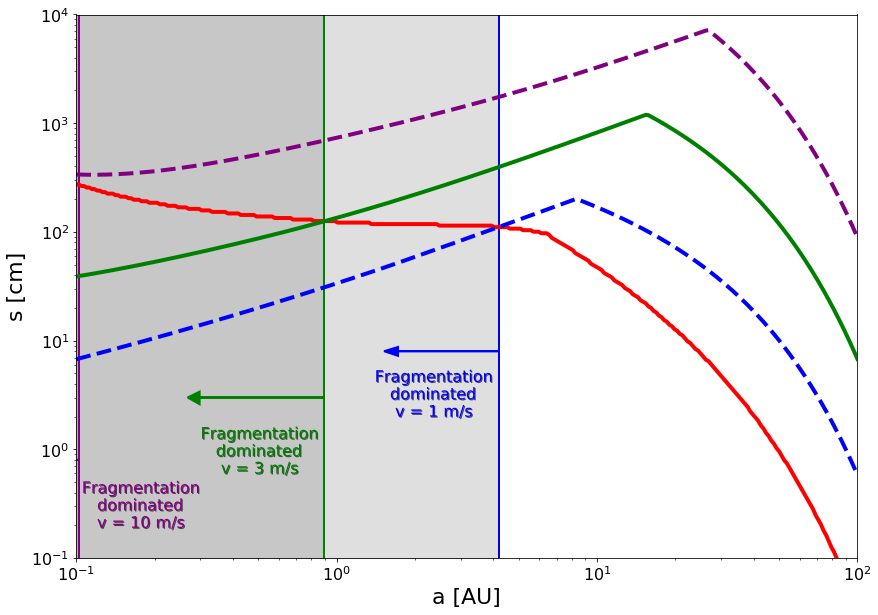

In [6]:
v_frag = np.array([1,3,10]) *1e2 #1, 3 and 10 m/s
f_f = 0.5 
f_d = 1e-2

rho_int = 1.6
params = [T_0, m_star, sig_0, r_crit, rho_int, 1e-5, a_edge]

s_array = np.logspace(-6,8,1000)
t_g_array = np.zeros(s_array.shape)
t_d_array = np.zeros(s_array.shape)
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    gamma = 1.0
    Sig = sig_0 * ((a/r_crit)**(-gamma))*np.exp(-(a/r_crit)**(2-gamma))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    #v_kep = np.sqrt(fn.G * mstar/(a * fn.au))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        #St = (s * rho_int * np.pi)/(2 * Sig)
        t_g_array[i] = t_grow(s, a, f_d, params)
        t_d_array[i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array - t_d_array))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]
    
import matplotlib.patheffects as path_effects

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[0], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[1], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[2], alpha=0.25, color='grey')
plt.text(1.4e0,2e0, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(3e-1,6e-1, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(1.05e-1,1.9e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 8, -2.5, 0, linestyle='-', linewidth=2, width=0, head_width=1.5, head_length=.2, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 3, -0.6, 0, linestyle='-', linewidth=2, width=0, head_width=0.8, head_length=.03, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.8, -.02, 0, linestyle='-', linewidth=2, width=0, head_width=0.2, head_length=.01, fc='purple', ec='purple')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e2)
plt.ylim(1e-1,1e4)
#plt.legend()

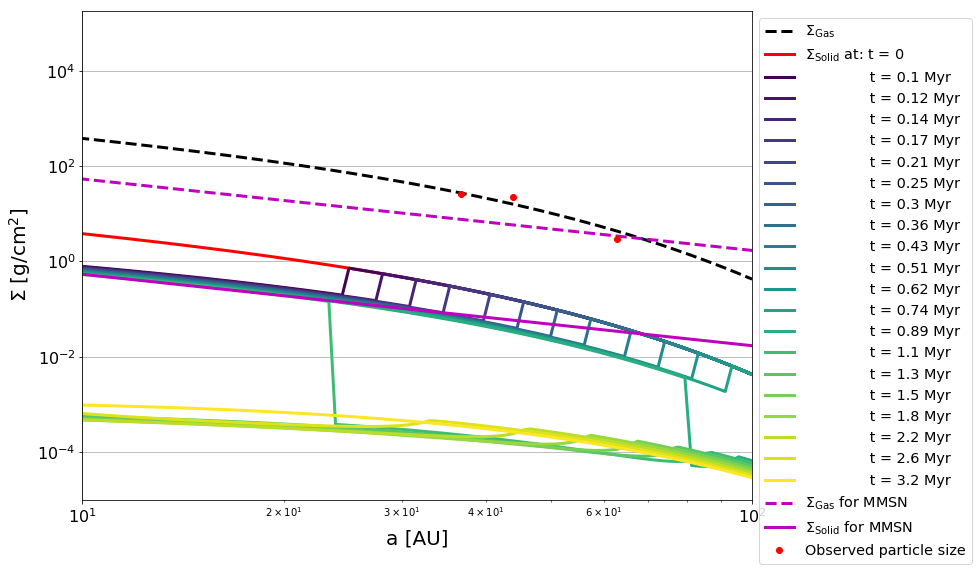

In [7]:
# Plotting surface densities for these times
t_array = np.logspace(-1,0.5, 20) * 3.154e13
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]
axis_font = {'size':'20'} # Sets font size
tick_font = {'size':'16'}

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k--', linewidth=3, label='$\Sigma_\mathrm{Gas}$')
plt.loglog(a_array, 1e-2*Sig_gas, 'r-', linewidth=3, label='$\Sigma_\mathrm{Solid}$ at: t = 0')
for i,t in enumerate(t_array):
    plt.loglog(a_array, sig_d_array[i], label='              t = {time} Myr'.format(time=f"{t/3.154e13:.2n}"), linewidth=3, color=line_colors[i])

plt.loglog(a_array, 1700*(a_array**(-3./2)), 'm--', label='$\Sigma_\mathrm{Gas}$ for MMSN', linewidth=3)
plt.loglog(a_array, 17*(a_array**(-3./2)), 'm-', label='$\Sigma_\mathrm{Solid}$ for MMSN', linewidth=3)

lambda_obs = np.array([[36.8, 43.9, 62.8], [0.705, 0.722, 0.13]])
T = T_0 * (lambda_obs[0]**(-3/7))
mstar = m_star * fn.m_sun
c_s = np.sqrt((boltzmann*T)/(2.35*mH))
Om = np.sqrt((fn.G*mstar)/(lambda_obs[0]*fn.au)**3.)
v_kep = Om * (lambda_obs[0]*fn.au)
eta = (c_s)**2/(2*(v_kep)**2)
v0 = eta * v_kep
t_disk = 3.154e13

Sig_obs = (2.5 * t_disk * v0 * rho_int * lambda_obs[1]/(2*np.pi))/(lambda_obs[0] * fn.au)
plt.loglog(lambda_obs[0], Sig_obs, 'ro', label='Observed particle size')

#plt.hlines(1000, 0.1, 100)
#plt.vlines(1, 10**-4, 10**4)
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e1, 1e2)
#plt.ylim(1e-1, 1e4)
plt.legend(loc=0, bbox_to_anchor=(1., 1., 0., 0.), fontsize='x-large')
plt.savefig('DRTau_SurfaceDensity.png')
plt.grid()
plt.show()

In [8]:
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
t_array = np.linspace(0.1, 3, 6) * 3.154e13 #np.logspace(-1,0.5, 6) * 3.154e13
t_grow_DRTau_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            c_s = fn.sound_speed(temp)
            v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
            eta = fn.eta(c_s, v_k)
            v_0 = eta * v_k
            v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
            if a_PF > a_edge and a_au > a_interior[k]:
                St = (a_au*fn.au)/(2 * v_g * t)
            else:
                St = np.sqrt(3)/8 * eps_p/eta * sig_d/sig_gas
            #St = (a_au*fn.au)/(2 * v_g * t)
            s = st_solver(st=St, alph=alpha, a_au=a_au, m_suns=m_star, m_earths=m_c, temp_in=temp, sig_in=sig_gas)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s)
            t_grow_DRTau_arr[k,i,j] = core.t_acc

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


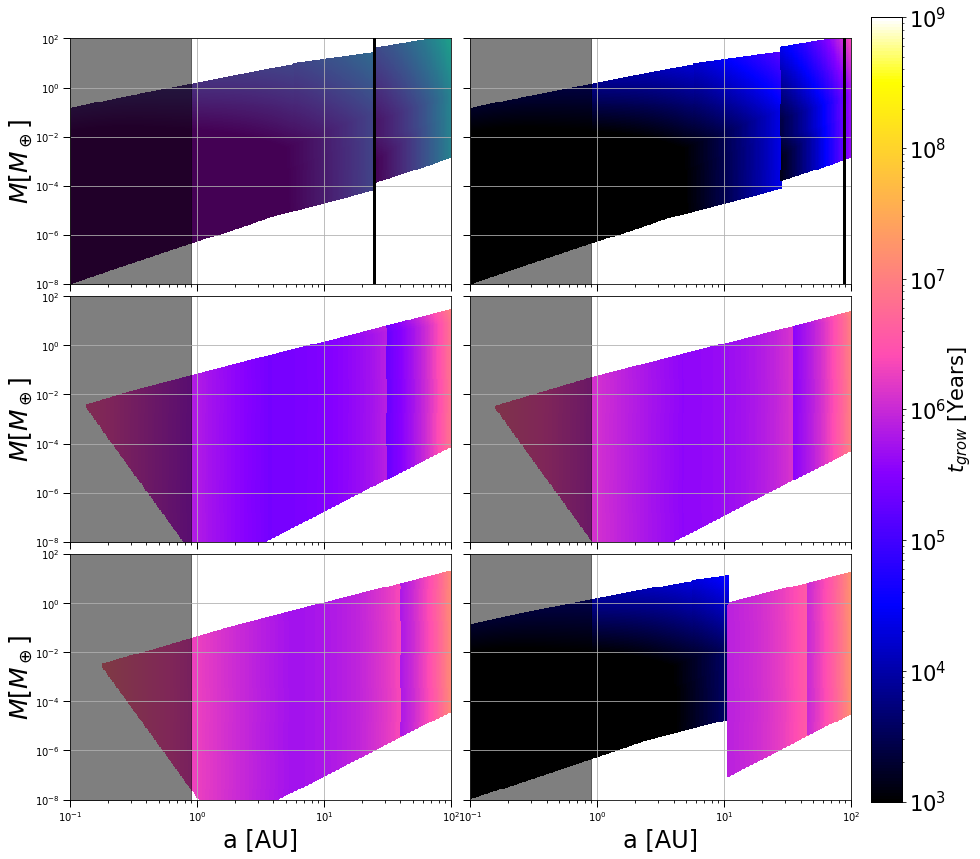

In [9]:
from matplotlib import gridspec
import matplotlib.image as im

# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.05, hspace=0.05)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_DRTau_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e3,vmax=1e9)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e-1, 1e2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)

In [10]:
def rate_odeint(m,t,p):
    alph,a_au,m_suns,temp,sig_gas,sig_p,st,verbose = p
    cs = fn.sound_speed(temp)
    vth = fn.therm_vel(cs)
    om = fn.omega(m_suns*fn.m_sun, a_au*fn.au)
    H_g = cs/om
    rho_g = sig_gas/2./H_g
    rho_s = 1.6
    vk = a_au*fn.au*om
    v0 = cs**2./2./vk
    v_g = np.sqrt(v0**2 + alph*cs**2)
    m_earths = m/fn.m_earth
    st = (a_au*fn.au)/(2 * v_g * t)
    s = st_solver(st=st,alph=alph,a_au=a_au,sig_in=sig_gas,temp_in=temp,m_earths=m_earths)
    if np.isnan(s) or s < 0 or m < 0:
        print("Bad radius/mass")
        s = np.abs(s)
        m = np.abs(m)
        
    # Calculates flow isolation mass
    term1 = np.sqrt(st)
    term2 = 1
    term3 = (cs/v_g * st)
    min1 = np.minimum(term1, term2)
    pre_fac = np.minimum(min1, term3)
    M_flow = (H_g/(a_au*fn.au))**3 * pre_fac * fn.m_sun
    B = 2*np.sqrt(3)
    M_iso = (4 * np.pi * B * (a_au*fn.au)**2 * sig_p)**(3/2) / (3 * m_suns*fn.m_sun)**(1/2) # GF isolation mass
    M_peb_iso = 20 * fn.m_earth * (H_g/(a_au*fn.au)/0.05)**3
    m_iso = min(M_iso, M_peb_iso)
    
    rp = (3*m/(4. * np.pi * rho_s))**(1./3.) # Core radius
    v_esc = np.sqrt(2*fn.G*m/rp) 

    H_turb = np.sqrt(alph/(alph+st))*H_g
    H_KH = 2*v0/om
    H_p = max(H_turb,H_KH)
    rho_solid = sig_p/2./H_p
    v_turb = np.sqrt(alph)*cs/np.sqrt(1 + st)
    v_lam = v0*np.sqrt(1 + 4.*st**2.)/(1 + st**2.)
    v_inf = max(v_turb,v_lam)
    bGF = rp*(1 + (v_esc/v_inf)**2.)**(0.5)
    H_acc = min(H_p,bGF)
    sig_acc = 4*bGF*H_acc
    rate_GF = rho_solid*sig_acc*v_inf

    core = Core(a_core_au=a_au, m_core_earthmasses=m_earths, alpha=alph, m_star_solarmasses=m_suns, temp_in=temp,
                sig_p_in=sig_p, sig_g_in=sig_gas)
    core.main(s)
    
    # Trying out a loop to tests growth with particles smaller than maximally sized
    t_acc = core.t_acc
    count = 0
    while t_acc == 0:
        core.main(.9*s)
        t_acc = core.t_acc
        count = count + 1
        if count >= 10:
            break
    if t_acc == 0:
        rate_peb = rate_GF
    else:        
        rate_peb = m/(core.t_acc*3.154e7)
    r_ws = core.r_ws
    h_r = core.r_hill
    b_r = core.r_bondi
    b_shear = core.r_sh
    r_tmp = min(r_ws,b_shear)
    r_stab = min(r_tmp,h_r)
    if bGF > r_stab:
        if m > M_iso:
            if m > M_flow:
                return 0
            else:
                rate = rate_peb
                if np.isinf(rate_peb):
                    if verbose: print("Pebble accretion is off")
                    return 0
        else:
            rate = rate_GF
        if np.isinf(rate_GF):
            print("Gravitational Focusing is broken")
    else:
        if m > M_flow:
            return 0
        rate = rate_peb
        if np.isinf(rate_peb):
            if verbose: print("Pebble accretion is off")
            rate = rate_GF
    return rate

In [11]:
# Try integrating core masses as the disk evolves
m0_arr = np.multiply([1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7],fn.m_earth)
t_array = np.logspace(-1,0.5, 100) * 3.154e13
a_array = np.array([1,3,5,10,30,100])
sig_d_array = np.zeros([t_array.size, a_array.size])
params = [T_0, m_star, sig_0, r_crit, rho_int, alpha, a_edge]
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

n_int = 1000 # Number of internal integrations between disk evolution time-steps
m_arr = np.zeros((len(a_array), len(m0_arr), n_int*len(t_array)))


for i,a_au in enumerate(a_array):
    sig_gas = Sig_gas[i]
    temp = T_0*a_au**(-3./7.)
    c_s = fn.sound_speed(temp)
    v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
    v_0 = fn.eta(c_s, v_k) * v_k
    v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
    for j,m0 in enumerate(m0_arr):
        for k,t in enumerate(t_array):
            if k == 0:
                mass = m0
                m_final = m0
            else:
                mass = m_final
            st = (a_au*fn.au)/(2 * v_g * t)
            
            if k == 99:
                times = np.logspace(np.log10(t),np.log10(t + (t - t_array[k-1])),n_int) #np.linspace(t,t + (t - t_array[-2]),100)
            else:
                times = np.logspace(np.log10(t),np.log10(t_array[k+1]),n_int) #np.linspace(t,t_array[k+1],100)
            p = [alpha,a_au,m_star,temp,sig_gas,sig_d_array[k,i],st,0]
            wsol = odeint(rate_odeint,mass,times,args=(p,))
            m_arr[i,j,n_int*k:n_int*k+n_int] = wsol.flatten()
            m_final = max(m_final, wsol.flatten()[-1])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


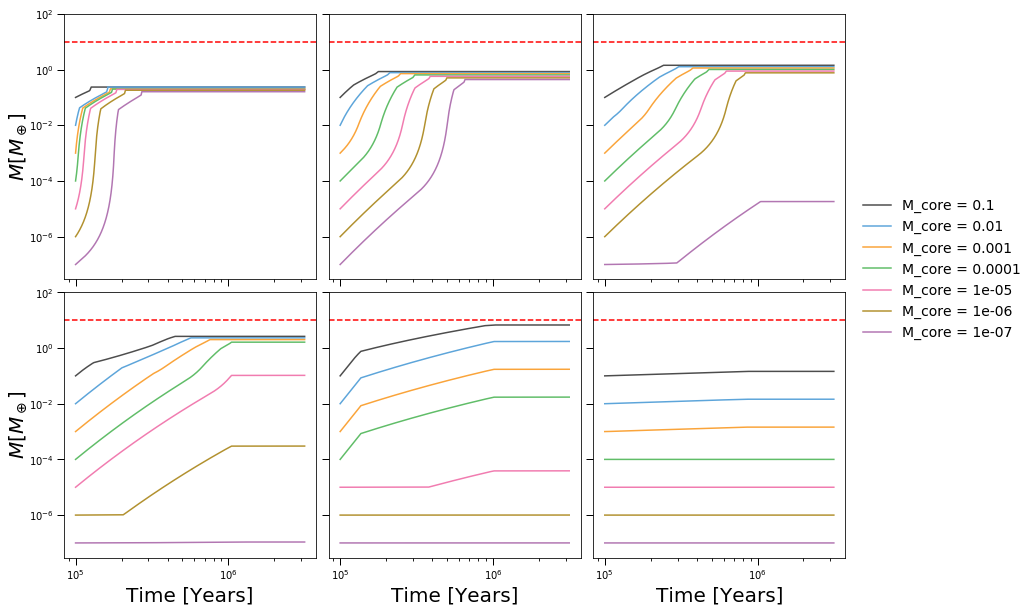

In [12]:
fig = plt.figure(figsize=(14,10))
plt.title(r'$\alpha = 1 \times 10^{-6}, \, St = \frac{a}{2 v_{g} t_\mathrm{disk}}$',y=1.01)
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.05, hspace=0.05)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}
t_array = np.logspace(-1,0.5, 100000) * 3.154e13

ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[0,2])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[1,2])

for i in range(len(m0_arr)):
    ax0.loglog(t_array*fn.sec_to_years,m_arr[0,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax1.loglog(t_array*fn.sec_to_years,m_arr[1,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax2.loglog(t_array*fn.sec_to_years,m_arr[2,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax3.loglog(t_array*fn.sec_to_years,m_arr[3,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax4.loglog(t_array*fn.sec_to_years,m_arr[4,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax5.loglog(t_array*fn.sec_to_years,m_arr[5,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))

for i in range(6):
    if i == 0:ax = ax0
    if i == 1: ax = ax1
    if i == 2: ax = ax2
    if i == 3: ax = ax3
    if i == 4: ax = ax4
    if i == 5: ax = ax5
    
    if i == 3 or i == 4 or i == 5:
        ax.set_xlabel('Time [Years]',fontsize=20)
    else:
        ax.tick_params(labelbottom=False) 
    if i == 0 or i == 3:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=20,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    
    ax.axhline(y=1e1,linestyle='dashed',color='r')
    ax.set_ylim(3e-8,1e2)
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)

lgd = plt.gca().legend(bbox_to_anchor=[1.02,1.4],frameon=False, fontsize=14)

plt.tight_layout()

In [13]:
# FT Tau time-series
params = np.loadtxt("fttau_params.txt")
m_star, T_0, sig_0, r_crit, alpha, t_disk = params
print("Stellar mass: ", m_star, "Alpha: ", alpha, "Sigma_0: ", sig_0, "T_0: ", T_0)
m_star = 0.55
r_crit = 28
sig_0 = 183
T_0 = 89

t_array = np.logspace(-1,0.5, 12) * 3.154e13
a_array = np.logspace(-1, 2, 300)
sig_d_array = np.zeros([t_array.size, a_array.size])

params = [T_0, m_star, sig_0, r_crit, rho_int, alpha, a_edge]

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

Stellar mass:  0.298 Alpha:  1e-06 Sigma_0:  125.0 T_0:  89.0565323094


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


(0.1, 10000.0)

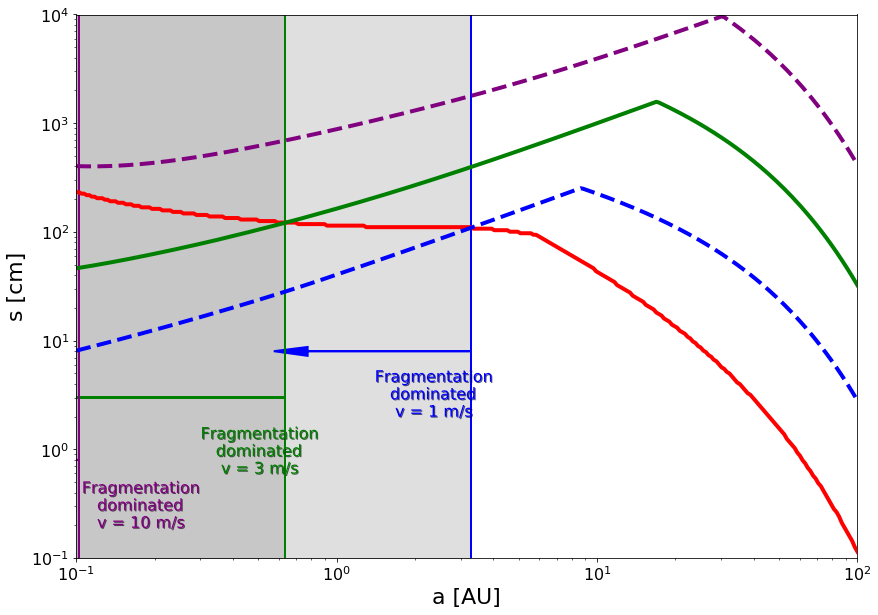

In [14]:
v_frag = np.array([1,3,10]) *1e2 #1, 3 and 10 m/s
f_f = 0.5 
f_d = 1e-2

rho_int = 1.6
params = [T_0, m_star, sig_0, r_crit, rho_int, 1e-5, a_edge]

s_array = np.logspace(-6,8,1000)
t_g_array = np.zeros(s_array.shape)
t_d_array = np.zeros(s_array.shape)
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    gamma = 1.0
    Sig = sig_0 * ((a/r_crit)**(-gamma))*np.exp(-(a/r_crit)**(2-gamma))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    #v_kep = np.sqrt(fn.G * mstar/(a * fn.au))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        #St = (s * rho_int * np.pi)/(2 * Sig)
        t_g_array[i] = t_grow(s, a, f_d, params)
        t_d_array[i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array - t_d_array))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]
    
import matplotlib.patheffects as path_effects

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[0], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[1], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[2], alpha=0.25, color='grey')
plt.text(1.4e0,2e0, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(3e-1,6e-1, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(1.05e-1,1.9e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 8, -2.5, 0, linestyle='-', linewidth=2, width=0, head_width=1.5, head_length=.2, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 3, -0.6, 0, linestyle='-', linewidth=2, width=0, head_width=0.8, head_length=.03, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.8, -.02, 0, linestyle='-', linewidth=2, width=0, head_width=0.2, head_length=.01, fc='purple', ec='purple')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e2)
plt.ylim(1e-1,1e4)

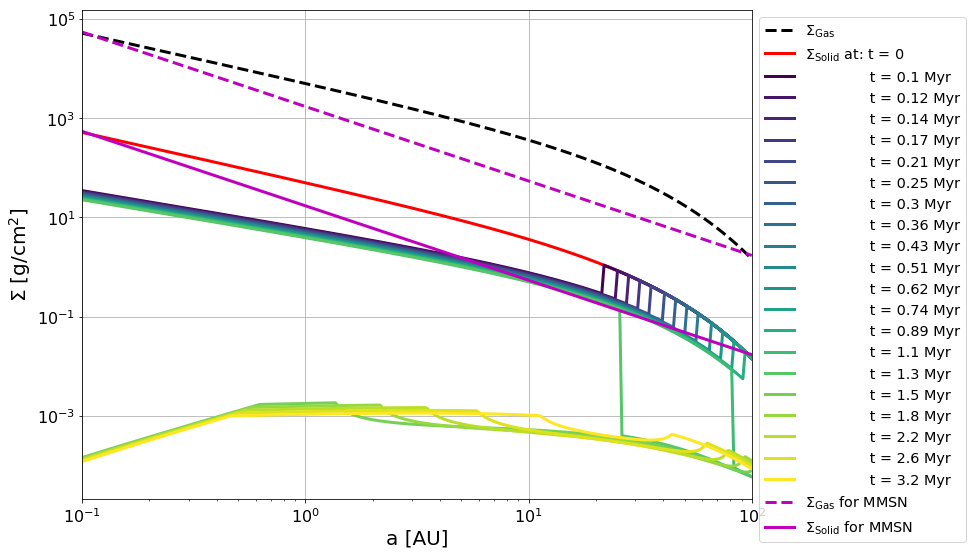

In [15]:
# Plotting surface densities for these times
t_array = np.logspace(-1,0.5, 20) * 3.154e13
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]
axis_font = {'size':'20'} # Sets font size
tick_font = {'size':'16'}

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k--', linewidth=3, label='$\Sigma_\mathrm{Gas}$')
plt.loglog(a_array, 1e-2*Sig_gas, 'r-', linewidth=3, label='$\Sigma_\mathrm{Solid}$ at: t = 0')
for i,t in enumerate(t_array):
    plt.loglog(a_array, sig_d_array[i], label='              t = {time} Myr'.format(time=f"{t/3.154e13:.2n}"), linewidth=3, color=line_colors[i])

plt.loglog(a_array, 1700*(a_array**(-3./2)), 'm--', label='$\Sigma_\mathrm{Gas}$ for MMSN', linewidth=3)
plt.loglog(a_array, 17*(a_array**(-3./2)), 'm-', label='$\Sigma_\mathrm{Solid}$ for MMSN', linewidth=3)

#plt.hlines(1000, 0.1, 100)
#plt.vlines(1, 10**-4, 10**4)
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1, 1e2)
#plt.ylim(1e-1, 1e4)
plt.legend(loc=0, bbox_to_anchor=(1., 1., 0., 0.), fontsize='x-large')
plt.savefig('FTTau_SurfaceDensity.png')
plt.grid()
plt.show()

In [16]:
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
t_array = np.linspace(0.1, 3, 6) * 3.154e13 #np.logspace(-1,0.5, 6) * 3.154e13
t_grow_FTTau_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            c_s = fn.sound_speed(temp)
            v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
            eta = fn.eta(c_s, v_k)
            v_0 = eta * v_k
            v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
            if a_PF > a_edge and a_au > a_interior[k]:
                St = (a_au*fn.au)/(2 * v_g * t)
            else:
                St = np.sqrt(3)/8 * eps_p/eta * sig_d/sig_gas
            #St = (a_au*fn.au)/(2 * v_g * t)
            s = st_solver(st=St, alph=alpha, a_au=a_au, m_suns=m_star, m_earths=m_c, temp_in=temp, sig_in=sig_gas)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s)
            t_grow_FTTau_arr[k,i,j] = core.t_acc

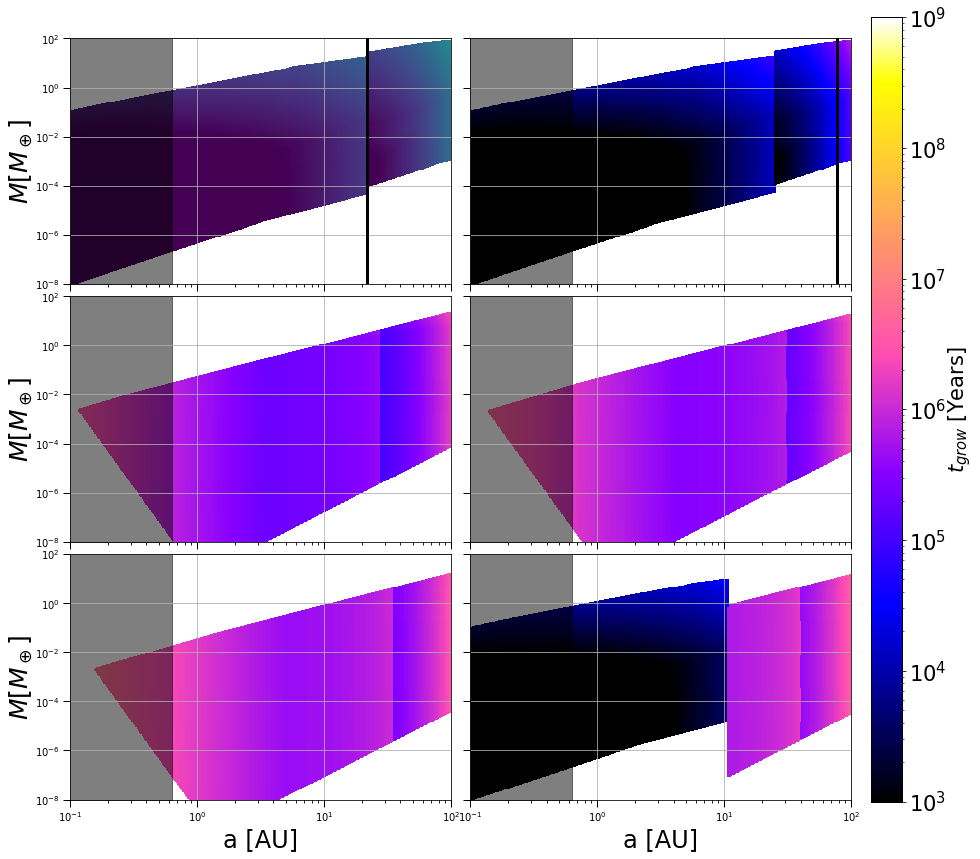

In [17]:
from matplotlib import gridspec
import matplotlib.image as im

# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.05, hspace=0.05)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_FTTau_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e3,vmax=1e9)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e-1, 1e2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)

In [18]:
# Try integrating core masses as the disk evolves
m0_arr = np.multiply([1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7],fn.m_earth)
t_array = np.logspace(-1,0.5, 100) * 3.154e13
a_array = np.array([1,3,5,10,30,100])
sig_d_array = np.zeros([t_array.size, a_array.size])
params = [T_0, m_star, sig_0, r_crit, rho_int, alpha, a_edge]
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

n_int = 1000 # Number of internal integrations between disk evolution time-steps
m_arr = np.zeros((len(a_array), len(m0_arr), n_int*len(t_array)))


for i,a_au in enumerate(a_array):
    sig_gas = Sig_gas[i]
    temp = T_0*a_au**(-3./7.)
    c_s = fn.sound_speed(temp)
    v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
    v_0 = fn.eta(c_s, v_k) * v_k
    v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
    for j,m0 in enumerate(m0_arr):
        for k,t in enumerate(t_array):
            if k == 0:
                mass = m0
                m_final = m0
            else:
                mass = m_final
            st = (a_au*fn.au)/(2 * v_g * t)
            
            if k == 99:
                times = np.logspace(np.log10(t),np.log10(t + (t - t_array[k-1])),n_int) #np.linspace(t,t + (t - t_array[-2]),100)
            else:
                times = np.logspace(np.log10(t),np.log10(t_array[k+1]),n_int) #np.linspace(t,t_array[k+1],100)
            p = [alpha,a_au,m_star,temp,sig_gas,sig_d_array[k,i],st,0]
            wsol = odeint(rate_odeint,mass,times,args=(p,))
            m_arr[i,j,n_int*k:n_int*k+n_int] = wsol.flatten()
            m_final = max(m_final, wsol.flatten()[-1])

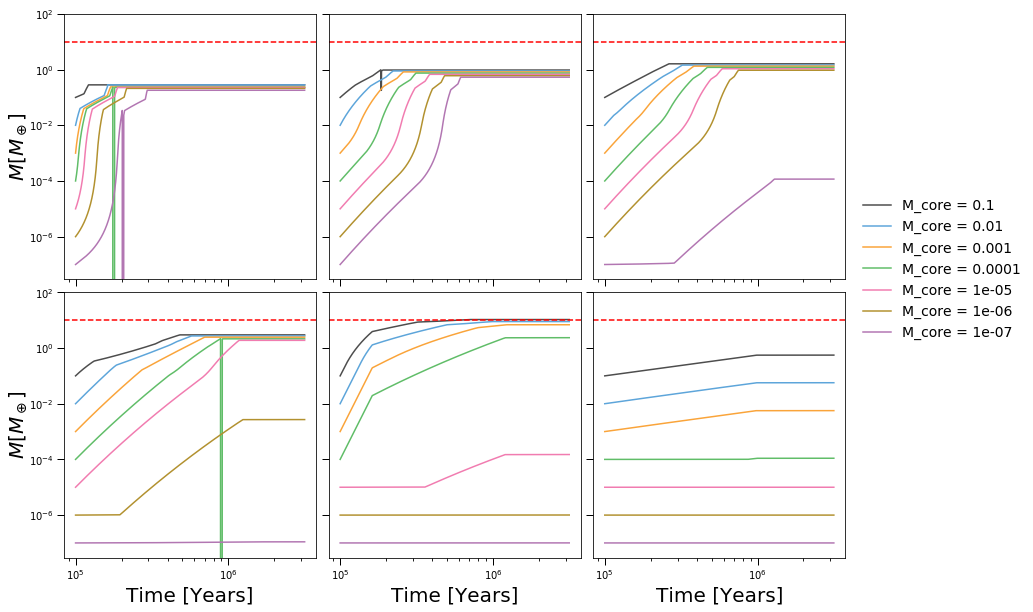

In [19]:
fig = plt.figure(figsize=(14,10))
plt.title(r'$\alpha = 1 \times 10^{-6}, \, St = \frac{a}{2 v_{g} t_\mathrm{disk}}$',y=1.01)
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.05, hspace=0.05)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}
t_array = np.logspace(-1,0.5, 100000) * 3.154e13

ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[0,2])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[1,2])

for i in range(len(m0_arr)):
    ax0.loglog(t_array*fn.sec_to_years,m_arr[0,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax1.loglog(t_array*fn.sec_to_years,m_arr[1,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax2.loglog(t_array*fn.sec_to_years,m_arr[2,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax3.loglog(t_array*fn.sec_to_years,m_arr[3,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax4.loglog(t_array*fn.sec_to_years,m_arr[4,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax5.loglog(t_array*fn.sec_to_years,m_arr[5,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))

for i in range(6):
    if i == 0:ax = ax0
    if i == 1: ax = ax1
    if i == 2: ax = ax2
    if i == 3: ax = ax3
    if i == 4: ax = ax4
    if i == 5: ax = ax5
    
    if i == 3 or i == 4 or i == 5:
        ax.set_xlabel('Time [Years]',fontsize=20)
    else:
        ax.tick_params(labelbottom=False) 
    if i == 0 or i == 3:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=20,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    
    ax.axhline(y=1e1,linestyle='dashed',color='r')
    ax.set_ylim(3e-8,1e2)
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)

lgd = plt.gca().legend(bbox_to_anchor=[1.02,1.4],frameon=False, fontsize=14)

plt.tight_layout()

In [20]:
# HD 163296 time-series
params = 2.3, 284, 29, 119, 1e-5, 5 * 3.154e13
m_star, T_0, sig_0, r_crit, alpha, t_disk = params
print("Stellar mass: ", m_star, "Alpha: ", alpha, "Sigma_0: ", sig_0, "T_0: ", T_0)

t_array = np.logspace(-1,0.5, 12) * 3.154e13
a_array = np.logspace(-1, 2.5, 300)
sig_d_array = np.zeros([t_array.size, a_array.size])

a_edge = 250
params = [T_0, m_star, sig_0, r_crit, rho_int, alpha, a_edge]

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

Stellar mass:  2.3 Alpha:  1e-05 Sigma_0:  29 T_0:  284


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


(0.1, 10000.0)

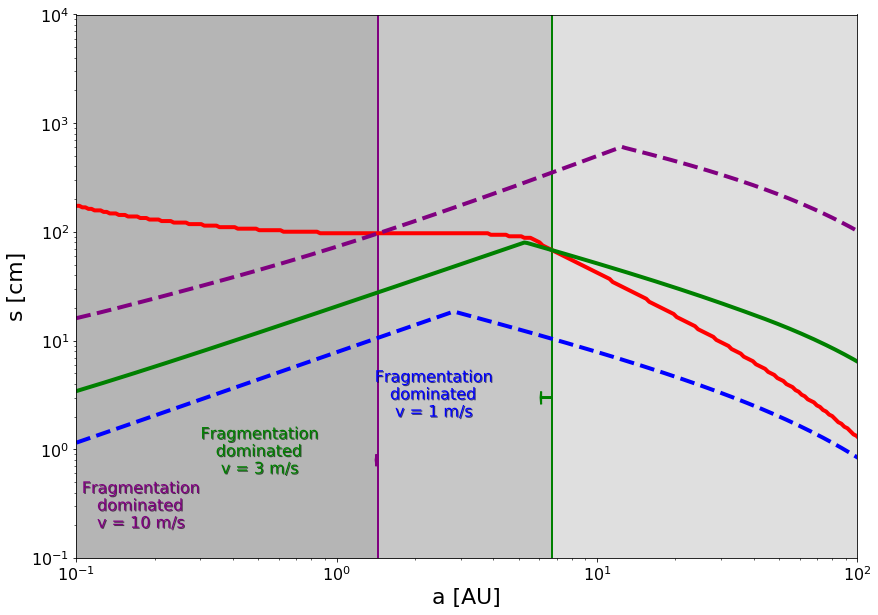

In [21]:
v_frag = np.array([1,3,10]) *1e2 #1, 3 and 10 m/s
f_f = 0.5 
f_d = 1e-2

rho_int = 1.6
params = [T_0, m_star, sig_0, r_crit, rho_int, 1e-5, a_edge]

s_array = np.logspace(-6,8,1000)
t_g_array = np.zeros(s_array.shape)
t_d_array = np.zeros(s_array.shape)
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    gamma = 1.0
    Sig = sig_0 * ((a/r_crit)**(-gamma))*np.exp(-(a/r_crit)**(2-gamma))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    #v_kep = np.sqrt(fn.G * mstar/(a * fn.au))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        #St = (s * rho_int * np.pi)/(2 * Sig)
        t_g_array[i] = t_grow(s, a, f_d, params)
        t_d_array[i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array - t_d_array))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]
    
import matplotlib.patheffects as path_effects

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[0], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[1], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[2], alpha=0.25, color='grey')
plt.text(1.4e0,2e0, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(3e-1,6e-1, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(1.05e-1,1.9e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 8, -2.5, 0, linestyle='-', linewidth=2, width=0, head_width=1.5, head_length=.2, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 3, -0.6, 0, linestyle='-', linewidth=2, width=0, head_width=0.8, head_length=.03, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.8, -.02, 0, linestyle='-', linewidth=2, width=0, head_width=0.2, head_length=.01, fc='purple', ec='purple')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e2)
plt.ylim(1e-1,1e4)

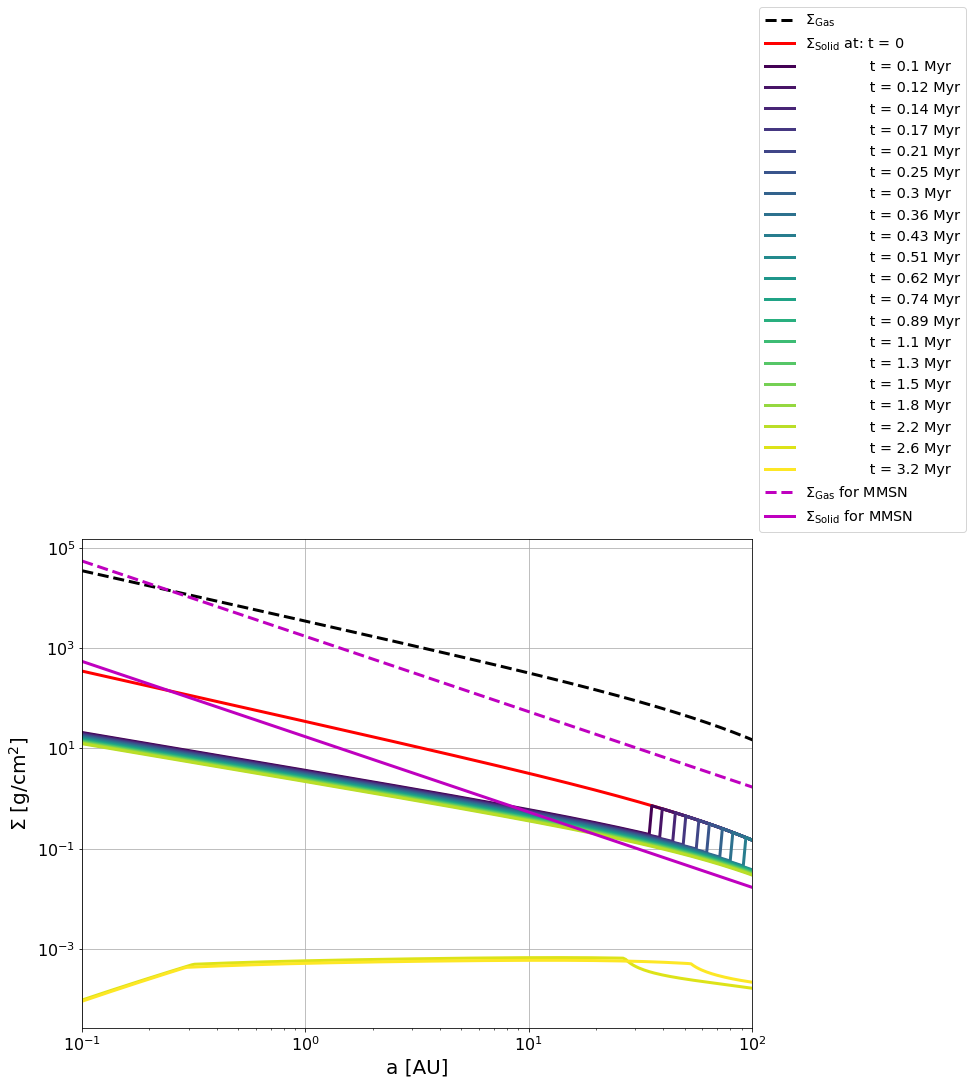

In [22]:
# Plotting surface densities for these times
t_array = np.logspace(-1,0.5, 20) * 3.154e13
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]
axis_font = {'size':'20'} # Sets font size
tick_font = {'size':'16'}

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k--', linewidth=3, label='$\Sigma_\mathrm{Gas}$')
plt.loglog(a_array, 1e-2*Sig_gas, 'r-', linewidth=3, label='$\Sigma_\mathrm{Solid}$ at: t = 0')
for i,t in enumerate(t_array):
    plt.loglog(a_array, sig_d_array[i], label='              t = {time} Myr'.format(time=f"{t/3.154e13:.2n}"), linewidth=3, color=line_colors[i])

plt.loglog(a_array, 1700*(a_array**(-3./2)), 'm--', label='$\Sigma_\mathrm{Gas}$ for MMSN', linewidth=3)
plt.loglog(a_array, 17*(a_array**(-3./2)), 'm-', label='$\Sigma_\mathrm{Solid}$ for MMSN', linewidth=3)

#plt.hlines(1000, 0.1, 100)
#plt.vlines(1, 10**-4, 10**4)
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1, 1e2)
#plt.ylim(1e-1, 1e4)
plt.legend(loc=0, bbox_to_anchor=(1., 1., 0., 0.), fontsize='x-large')
plt.savefig('HD163_SurfaceDensity.png')
plt.grid()
plt.show()

In [23]:
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
t_array = np.linspace(0.1, 3, 6) * 3.154e13 #np.logspace(-1,0.5, 6) * 3.154e13
t_grow_HD163_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            c_s = fn.sound_speed(temp)
            v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
            eta = fn.eta(c_s, v_k)
            v_0 = eta * v_k
            v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
            if a_PF > a_edge and a_au > a_interior[k]:
                St = (a_au*fn.au)/(2 * v_g * t)
            else:
                St = np.sqrt(3)/8 * eps_p/eta * sig_d/sig_gas
            #St = (a_au*fn.au)/(2 * v_g * t)
            s = st_solver(st=St, alph=alpha, a_au=a_au, m_suns=m_star, m_earths=m_c, temp_in=temp, sig_in=sig_gas)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s)
            t_grow_HD163_arr[k,i,j] = core.t_acc

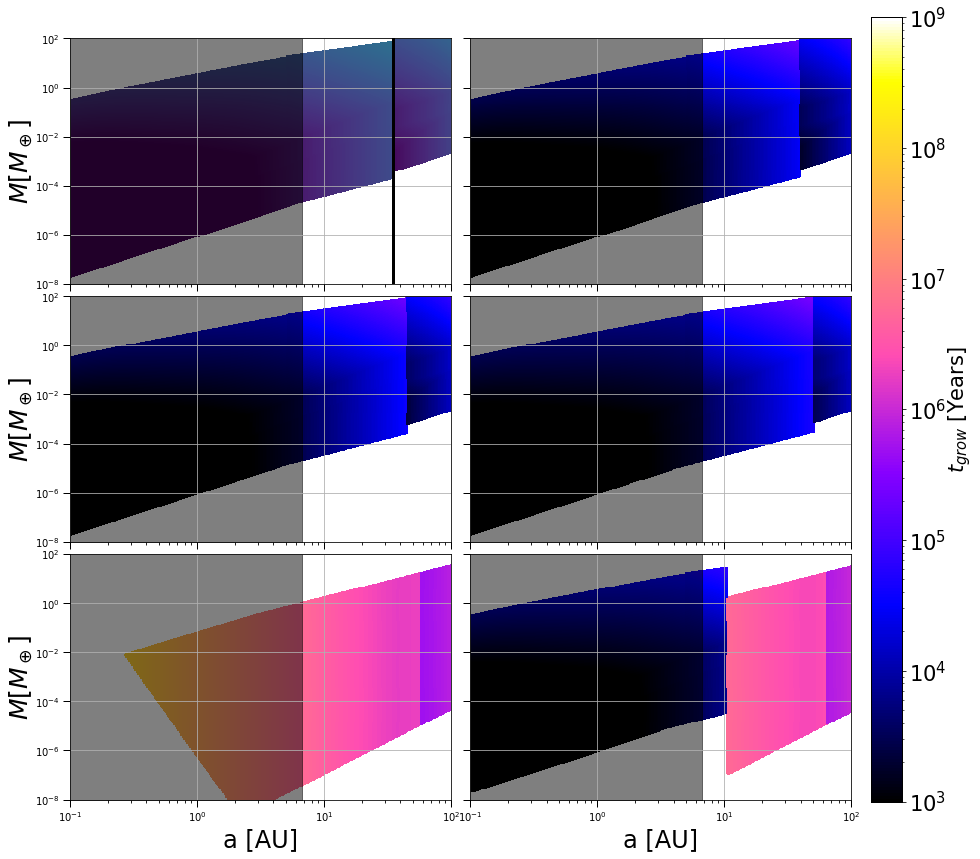

In [24]:
from matplotlib import gridspec
import matplotlib.image as im

# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.05, hspace=0.05)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_HD163_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e3,vmax=1e9)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e-1, 1e2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)

In [25]:
# DoAr 25 time-series (params from Andrews et al. 2009)
sig_SB = 5.6704e-5
M_d = 0.136
a_crit = 80
gamma = 0.9
L_star = 0.8
L_sun = 3.839e33
m_star = 1.0
sigma_0 = (2 - gamma)*(M_d*fn.m_sun)/(2*np.pi*(a_crit*fn.au)**2)
T_0 = (L_star*L_sun)**(2/7) * (1/(4 * sig_SB*np.pi))**(2/7) * (2/7)**(1/4) * (fn.k/(fn.mu * fn.G * m_star*fn.m_sun))**(1/7) * fn.au**(-3/7)
params = m_star, T_0, sigma_0, a_crit, 1e-5, 3.8 * 3.154e13
m_star, T_0, sig_0, r_crit, alpha, t_disk = params
print("Stellar mass: ", m_star, "Alpha: ", alpha, "Sigma_0: ", sig_0, "T_0: ", T_0)

t_array = np.logspace(-1,0.5, 12) * 3.154e13
a_array = np.logspace(-1, 2.5, 300)
sig_d_array = np.zeros([t_array.size, a_array.size])

a_edge = 300
params = [T_0, m_star, sig_0, r_crit, rho_int, alpha, a_edge]

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

Stellar mass:  1.0 Alpha:  1e-05 Sigma_0:  33.065686417562304 T_0:  107.32561966941165


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


(0.1, 10000.0)

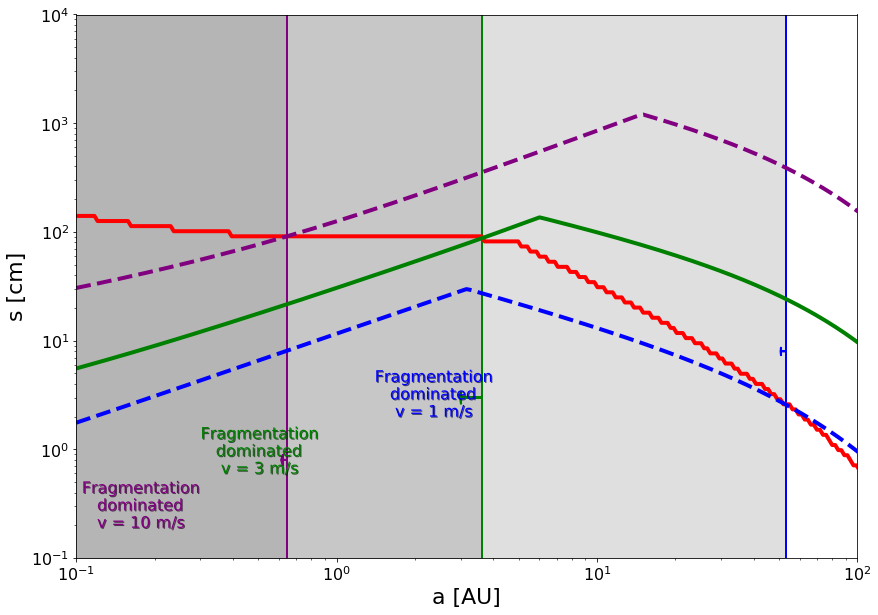

In [26]:
v_frag = np.array([1,3,10]) *1e2 #1, 3 and 10 m/s
f_f = 0.5 
f_d = 1e-2

rho_int = 1.6
params = [T_0, m_star, sig_0, r_crit, rho_int, 1e-5, a_edge]

s_array = np.logspace(-6,8,300)
t_g_array = np.zeros(s_array.shape)
t_d_array = np.zeros(s_array.shape)
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    gamma = 1.0
    Sig = sig_0 * ((a/r_crit)**(-gamma))*np.exp(-(a/r_crit)**(2-gamma))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    #v_kep = np.sqrt(fn.G * mstar/(a * fn.au))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        #St = (s * rho_int * np.pi)/(2 * Sig)
        t_g_array[i] = t_grow(s, a, f_d, params)
        t_d_array[i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array - t_d_array))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]
    
import matplotlib.patheffects as path_effects

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[0], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[1], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[2], alpha=0.25, color='grey')
plt.text(1.4e0,2e0, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(3e-1,6e-1, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(1.05e-1,1.9e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 8, -2.5, 0, linestyle='-', linewidth=2, width=0, head_width=1.5, head_length=.2, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 3, -0.6, 0, linestyle='-', linewidth=2, width=0, head_width=0.8, head_length=.03, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.8, -.02, 0, linestyle='-', linewidth=2, width=0, head_width=0.2, head_length=.01, fc='purple', ec='purple')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e2)
plt.ylim(1e-1,1e4)

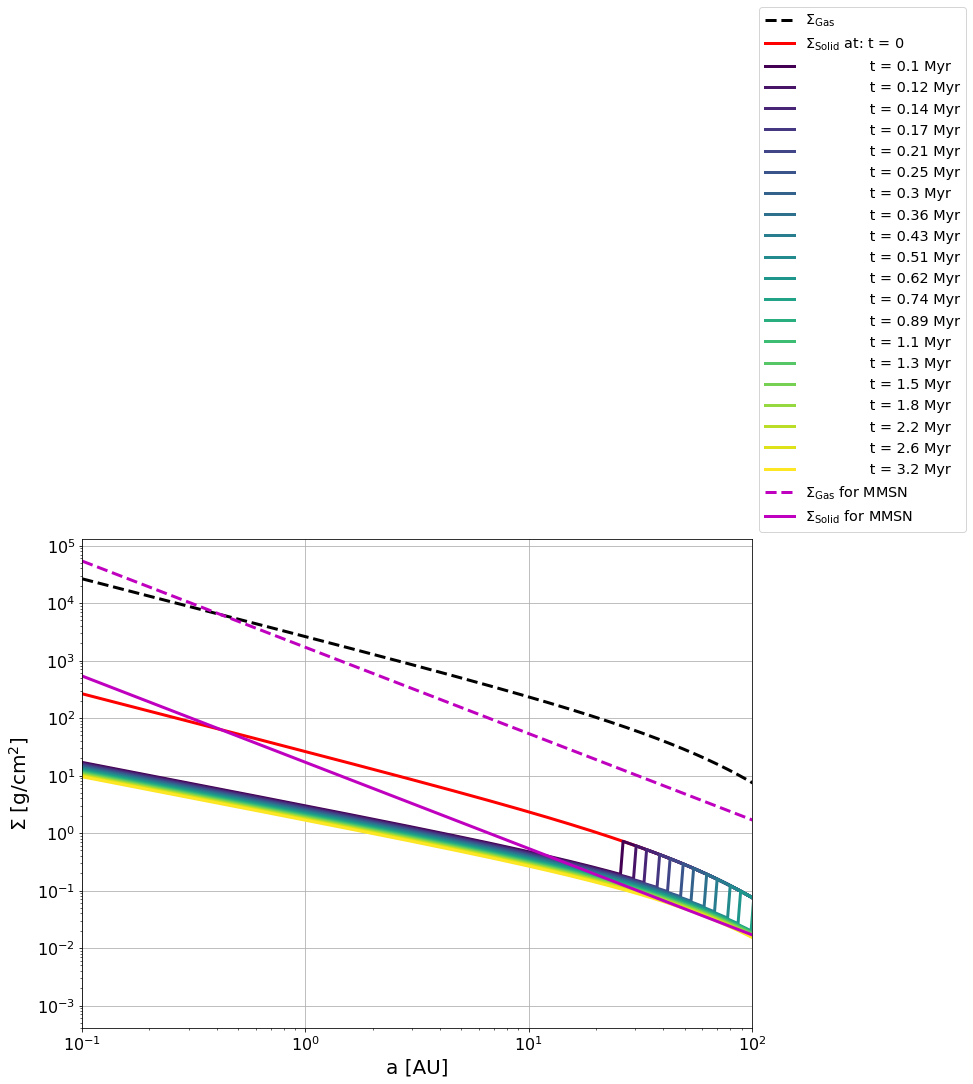

In [27]:
# Plotting surface densities for these times
t_array = np.logspace(-1,0.5, 20) * 3.154e13
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]
axis_font = {'size':'20'} # Sets font size
tick_font = {'size':'16'}

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k--', linewidth=3, label='$\Sigma_\mathrm{Gas}$')
plt.loglog(a_array, 1e-2*Sig_gas, 'r-', linewidth=3, label='$\Sigma_\mathrm{Solid}$ at: t = 0')
for i,t in enumerate(t_array):
    plt.loglog(a_array, sig_d_array[i], label='              t = {time} Myr'.format(time=f"{t/3.154e13:.2n}"), linewidth=3, color=line_colors[i])

plt.loglog(a_array, 1700*(a_array**(-3./2)), 'm--', label='$\Sigma_\mathrm{Gas}$ for MMSN', linewidth=3)
plt.loglog(a_array, 17*(a_array**(-3./2)), 'm-', label='$\Sigma_\mathrm{Solid}$ for MMSN', linewidth=3)

#plt.hlines(1000, 0.1, 100)
#plt.vlines(1, 10**-4, 10**4)
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1, 1e2)
#plt.ylim(1e-1, 1e4)
plt.legend(loc=0, bbox_to_anchor=(1., 1., 0., 0.), fontsize='x-large')
plt.savefig('DoAr25_SurfaceDensity.png')
plt.grid()
plt.show()

In [28]:
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
t_array = np.linspace(0.1, 3, 6) * 3.154e13 #np.logspace(-1,0.5, 6) * 3.154e13
t_grow_DoAr25_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            c_s = fn.sound_speed(temp)
            v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
            eta = fn.eta(c_s, v_k)
            v_0 = eta * v_k
            v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
            if a_PF > a_edge and a_au > a_interior[k]:
                St = (a_au*fn.au)/(2 * v_g * t)
            else:
                St = np.sqrt(3)/8 * eps_p/eta * sig_d/sig_gas
            #St = (a_au*fn.au)/(2 * v_g * t)
            s = st_solver(st=St, alph=alpha, a_au=a_au, m_suns=m_star, m_earths=m_c, temp_in=temp, sig_in=sig_gas)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s)
            t_grow_DoAr25_arr[k,i,j] = core.t_acc

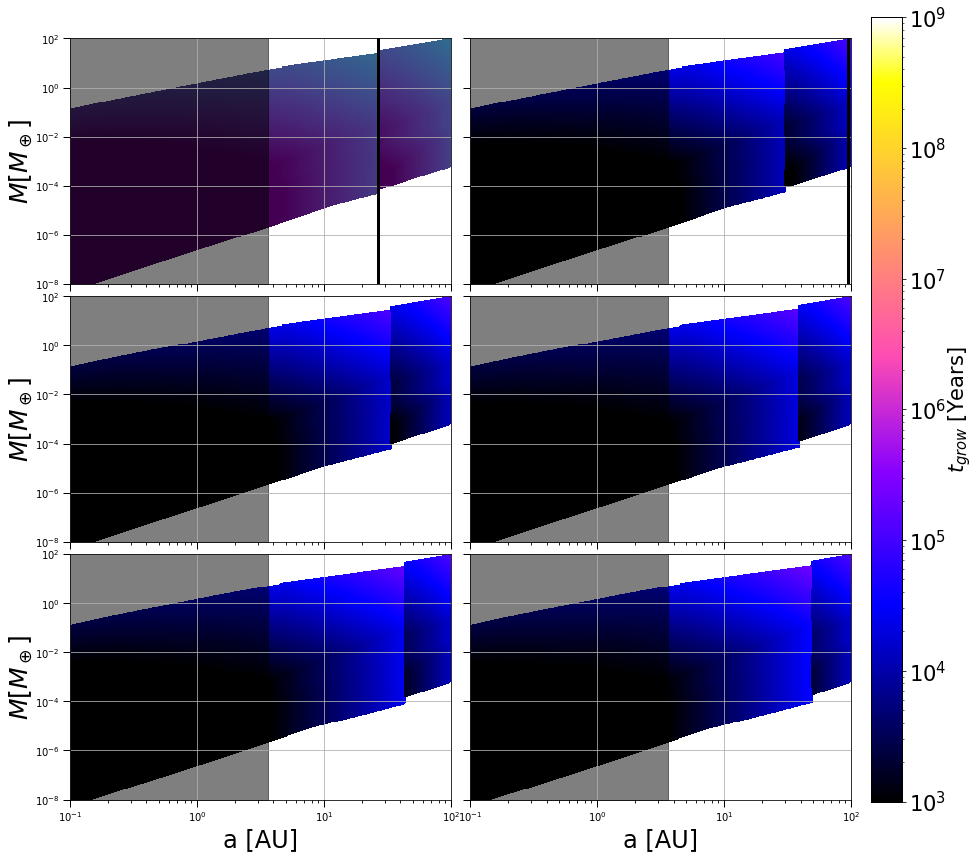

In [29]:
from matplotlib import gridspec
import matplotlib.image as im

# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.05, hspace=0.05)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_DoAr25_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e3,vmax=1e9)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e-1, 1e2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)

In [30]:
# AS 209 time-series (params from Andrews et al. 2009)
M_d = 0.028
a_crit = 126
gamma = 0.4
L_star = 1.5
m_star = 0.9
sigma_0 = (2 - gamma)*(M_d*fn.m_sun)/(2*np.pi*(a_crit*fn.au)**2)
T_0 = (L_star*L_sun)**(2/7) * (1/(4 * sig_SB*np.pi))**(2/7) * (2/7)**(1/4) * (fn.k/(fn.mu * fn.G * m_star*fn.m_sun))**(1/7) * fn.au**(-3/7)
params = m_star, T_0, sigma_0, a_crit, 1e-5, 1.6 * 3.154e13
m_star, T_0, sig_0, r_crit, alpha, t_disk = params
print("Stellar mass: ", m_star, "Alpha: ", alpha, "Sigma_0: ", sig_0, "T_0: ", T_0)

t_array = np.logspace(-1,0.5, 12) * 3.154e13
a_array = np.logspace(-1, 2.5, 300)
sig_d_array = np.zeros([t_array.size, a_array.size])

a_edge = 250
params = [T_0, m_star, sig_0, r_crit, rho_int, alpha, a_edge]

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

Stellar mass:  0.9 Alpha:  1e-05 Sigma_0:  3.991745523817045 T_0:  130.38887927432307


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


(0.1, 10000.0)

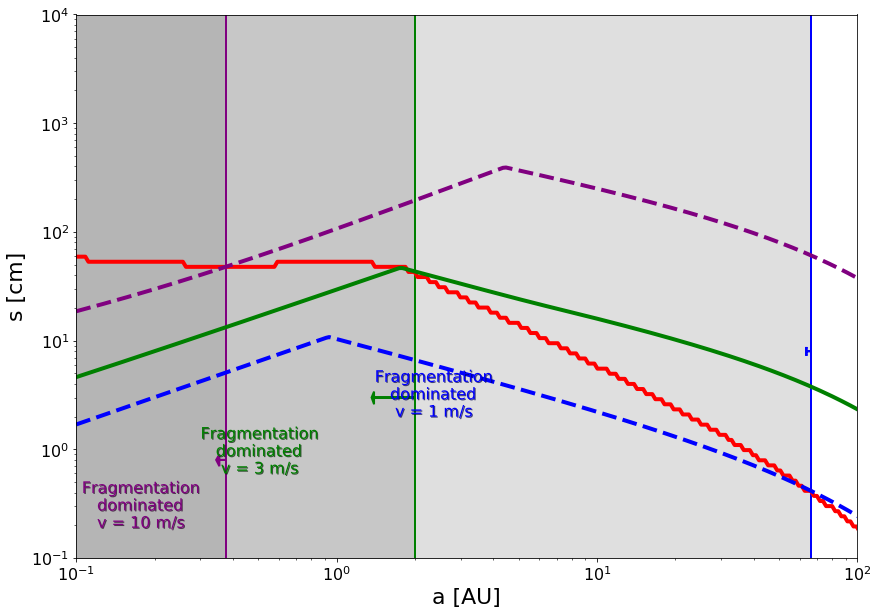

In [31]:
v_frag = np.array([1,3,10]) *1e2 #1, 3 and 10 m/s
f_f = 0.5 
f_d = 1e-2

rho_int = 1.6
params = [T_0, m_star, sig_0, r_crit, rho_int, 1e-5, a_edge]

s_array = np.logspace(-6,8,300)
t_g_array = np.zeros(s_array.shape)
t_d_array = np.zeros(s_array.shape)
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    gamma = 1.0
    Sig = sig_0 * ((a/r_crit)**(-gamma))*np.exp(-(a/r_crit)**(2-gamma))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    #v_kep = np.sqrt(fn.G * mstar/(a * fn.au))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        #St = (s * rho_int * np.pi)/(2 * Sig)
        t_g_array[i] = t_grow(s, a, f_d, params)
        t_d_array[i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array - t_d_array))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]
    
import matplotlib.patheffects as path_effects

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[0], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[1], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[2], alpha=0.25, color='grey')
plt.text(1.4e0,2e0, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(3e-1,6e-1, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(1.05e-1,1.9e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 8, -2.5, 0, linestyle='-', linewidth=2, width=0, head_width=1.5, head_length=.2, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 3, -0.6, 0, linestyle='-', linewidth=2, width=0, head_width=0.8, head_length=.03, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.8, -.02, 0, linestyle='-', linewidth=2, width=0, head_width=0.2, head_length=.01, fc='purple', ec='purple')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e2)
plt.ylim(1e-1,1e4)

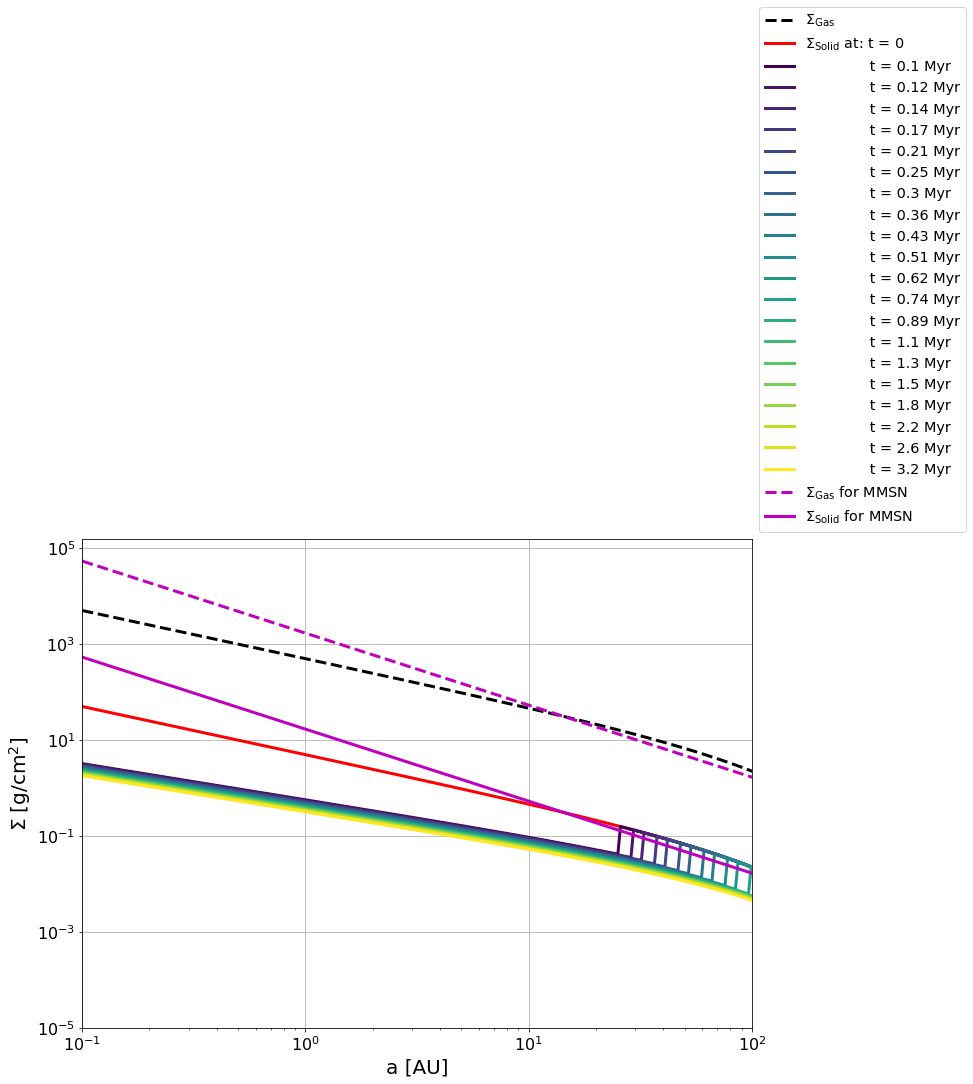

In [32]:
# Plotting surface densities for these times
t_array = np.logspace(-1,0.5, 20) * 3.154e13
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]
axis_font = {'size':'20'} # Sets font size
tick_font = {'size':'16'}

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k--', linewidth=3, label='$\Sigma_\mathrm{Gas}$')
plt.loglog(a_array, 1e-2*Sig_gas, 'r-', linewidth=3, label='$\Sigma_\mathrm{Solid}$ at: t = 0')
for i,t in enumerate(t_array):
    plt.loglog(a_array, sig_d_array[i], label='              t = {time} Myr'.format(time=f"{t/3.154e13:.2n}"), linewidth=3, color=line_colors[i])

plt.loglog(a_array, 1700*(a_array**(-3./2)), 'm--', label='$\Sigma_\mathrm{Gas}$ for MMSN', linewidth=3)
plt.loglog(a_array, 17*(a_array**(-3./2)), 'm-', label='$\Sigma_\mathrm{Solid}$ for MMSN', linewidth=3)

#plt.hlines(1000, 0.1, 100)
#plt.vlines(1, 10**-4, 10**4)
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1, 1e2)
#plt.ylim(1e-1, 1e4)
plt.legend(loc=0, bbox_to_anchor=(1., 1., 0., 0.), fontsize='x-large')
plt.savefig('AS209_SurfaceDensity.png')
plt.grid()
plt.show()

In [33]:
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
t_array = np.linspace(0.1, 3, 6) * 3.154e13 #np.logspace(-1,0.5, 6) * 3.154e13
t_grow_AS209_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            c_s = fn.sound_speed(temp)
            v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
            eta = fn.eta(c_s, v_k)
            v_0 = eta * v_k
            v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
            if a_PF > a_edge and a_au > a_interior[k]:
                St = (a_au*fn.au)/(2 * v_g * t)
            else:
                St = np.sqrt(3)/8 * eps_p/eta * sig_d/sig_gas
            #St = (a_au*fn.au)/(2 * v_g * t)
            s = st_solver(st=St, alph=alpha, a_au=a_au, m_suns=m_star, m_earths=m_c, temp_in=temp, sig_in=sig_gas)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s)
            t_grow_AS209_arr[k,i,j] = core.t_acc

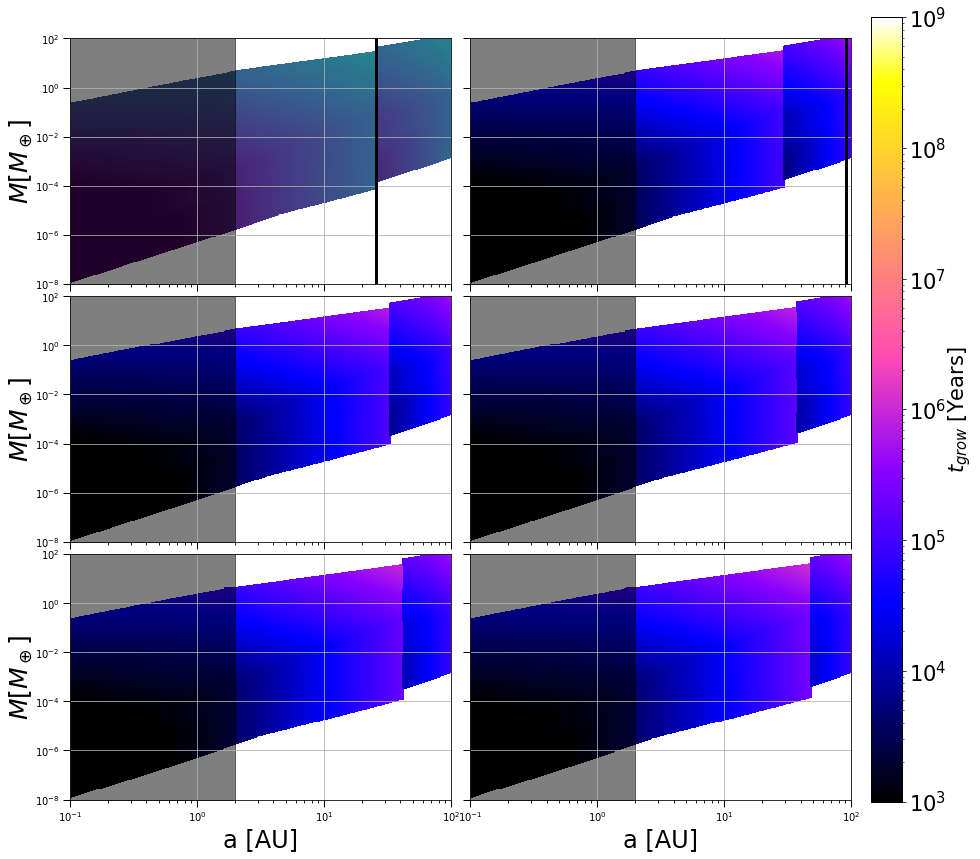

In [34]:
from matplotlib import gridspec
import matplotlib.image as im

# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.05, hspace=0.05)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_AS209_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e3,vmax=1e9)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e-1, 1e2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)

In [35]:
# VSSG 1 time-series (params from Andrews et al. 2009)
M_d = 0.029
a_crit = 33
gamma = 0.8
L_star = 1.9
m_star = 0.6
sigma_0 = (2 - gamma)*(M_d*fn.m_sun)/(2*np.pi*(a_crit*fn.au)**2)
T_0 = (L_star*L_sun)**(2/7) * (1/(4 * sig_SB*np.pi))**(2/7) * (2/7)**(1/4) * (fn.k/(fn.mu * fn.G * m_star*fn.m_sun))**(1/7) * fn.au**(-3/7)
params = m_star, T_0, sigma_0, a_crit, 1e-5, 0.7 * 3.154e13
m_star, T_0, sig_0, r_crit, alpha, t_disk = params
print("Stellar mass: ", m_star, "Alpha: ", alpha, "Sigma_0: ", sig_0, "T_0: ", T_0)

t_array = np.logspace(-1,0.5, 12) * 3.154e13
a_array = np.logspace(-1, 2.5, 300)
sig_d_array = np.zeros([t_array.size, a_array.size])

a_edge = 100
params = [T_0, m_star, sig_0, r_crit, rho_int, alpha, a_edge]

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

Stellar mass:  0.6 Alpha:  1e-05 Sigma_0:  45.20404383479591 T_0:  147.8184160593279


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


(0.1, 10000.0)

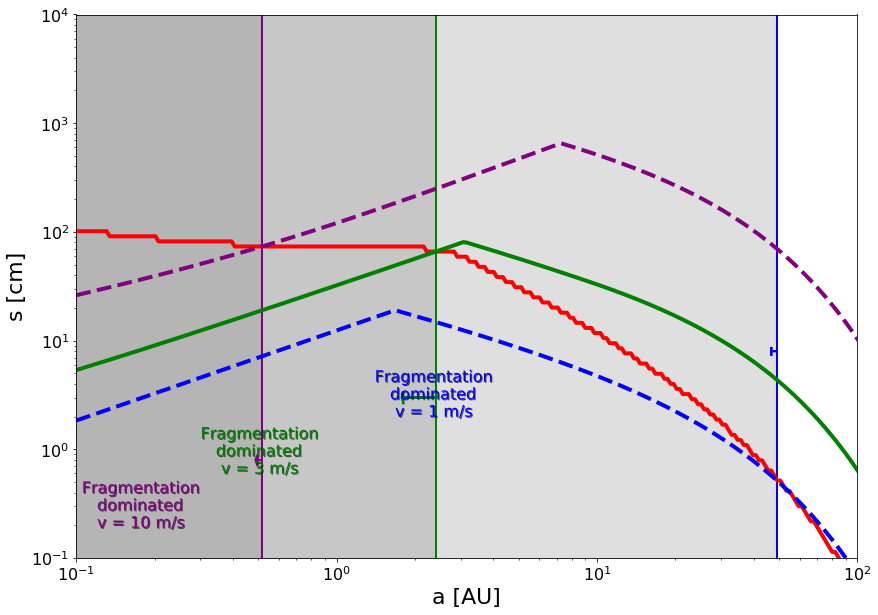

In [36]:
v_frag = np.array([1,3,10]) *1e2 #1, 3 and 10 m/s
f_f = 0.5 
f_d = 1e-2

rho_int = 1.6
params = [T_0, m_star, sig_0, r_crit, rho_int, 1e-5, a_edge]

s_array = np.logspace(-6,8,300)
t_g_array = np.zeros(s_array.shape)
t_d_array = np.zeros(s_array.shape)
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    gamma = 1.0
    Sig = sig_0 * ((a/r_crit)**(-gamma))*np.exp(-(a/r_crit)**(2-gamma))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    #v_kep = np.sqrt(fn.G * mstar/(a * fn.au))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        #St = (s * rho_int * np.pi)/(2 * Sig)
        t_g_array[i] = t_grow(s, a, f_d, params)
        t_d_array[i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array - t_d_array))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]
    
import matplotlib.patheffects as path_effects

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[0], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[1], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-1,4,100), 1e-1, frag_loc[2], alpha=0.25, color='grey')
plt.text(1.4e0,2e0, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(3e-1,6e-1, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(1.05e-1,1.9e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 8, -2.5, 0, linestyle='-', linewidth=2, width=0, head_width=1.5, head_length=.2, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 3, -0.6, 0, linestyle='-', linewidth=2, width=0, head_width=0.8, head_length=.03, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.8, -.02, 0, linestyle='-', linewidth=2, width=0, head_width=0.2, head_length=.01, fc='purple', ec='purple')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e2)
plt.ylim(1e-1,1e4)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


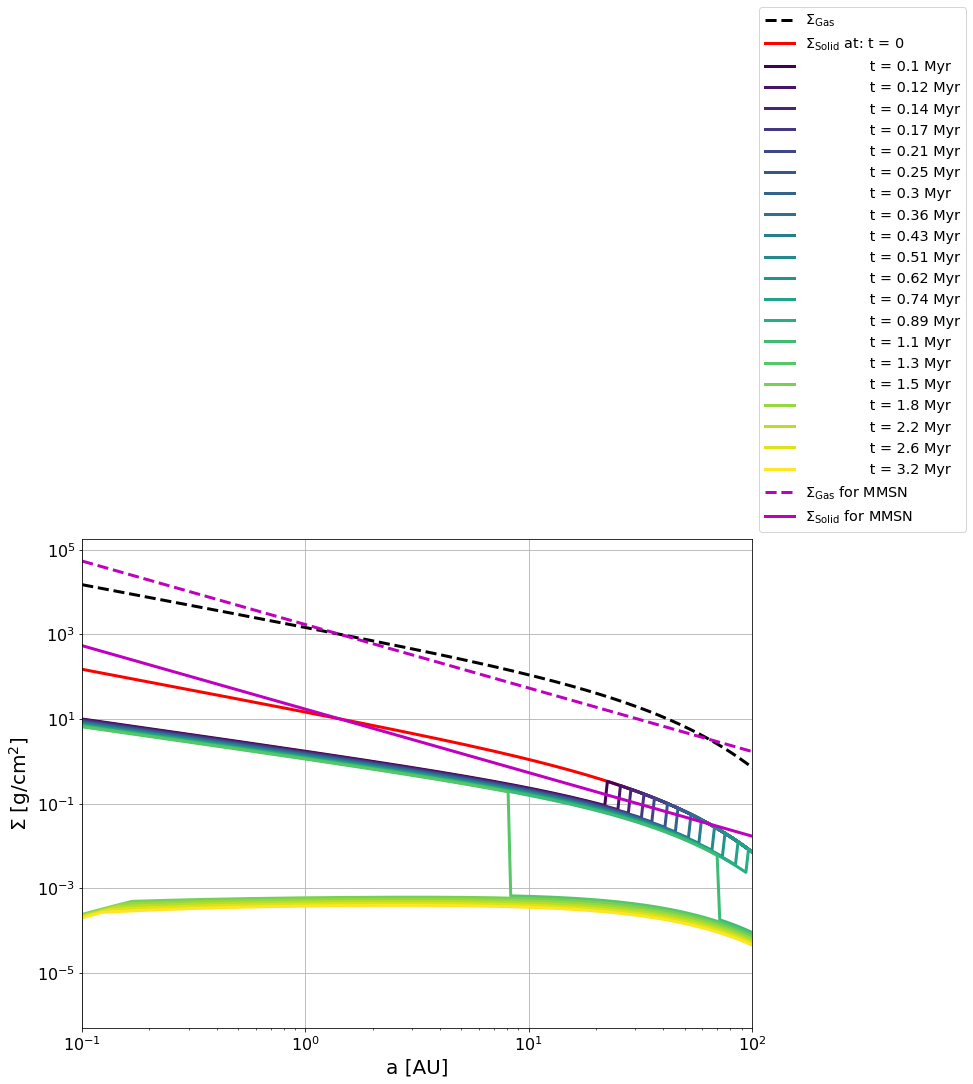

In [37]:
# Plotting surface densities for these times
t_array = np.logspace(-1,0.5, 20) * 3.154e13
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]
axis_font = {'size':'20'} # Sets font size
tick_font = {'size':'16'}

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k--', linewidth=3, label='$\Sigma_\mathrm{Gas}$')
plt.loglog(a_array, 1e-2*Sig_gas, 'r-', linewidth=3, label='$\Sigma_\mathrm{Solid}$ at: t = 0')
for i,t in enumerate(t_array):
    plt.loglog(a_array, sig_d_array[i], label='              t = {time} Myr'.format(time=f"{t/3.154e13:.2n}"), linewidth=3, color=line_colors[i])

plt.loglog(a_array, 1700*(a_array**(-3./2)), 'm--', label='$\Sigma_\mathrm{Gas}$ for MMSN', linewidth=3)
plt.loglog(a_array, 17*(a_array**(-3./2)), 'm-', label='$\Sigma_\mathrm{Solid}$ for MMSN', linewidth=3)

#plt.hlines(1000, 0.1, 100)
#plt.vlines(1, 10**-4, 10**4)
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1, 1e2)
#plt.ylim(1e-1, 1e4)
plt.legend(loc=0, bbox_to_anchor=(1., 1., 0., 0.), fontsize='x-large')
plt.savefig('VSSG1_SurfaceDensity.png')
plt.grid()
plt.show()

In [38]:
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
t_array = np.linspace(0.1, 3, 6) * 3.154e13 #np.logspace(-1,0.5, 6) * 3.154e13
t_grow_VSSG1_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            c_s = fn.sound_speed(temp)
            v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
            eta = fn.eta(c_s, v_k)
            v_0 = eta * v_k
            v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
            if a_PF > a_edge and a_au > a_interior[k]:
                St = (a_au*fn.au)/(2 * v_g * t)
            else:
                St = np.sqrt(3)/8 * eps_p/eta * sig_d/sig_gas
            #St = (a_au*fn.au)/(2 * v_g * t)
            s = st_solver(st=St, alph=alpha, a_au=a_au, m_suns=m_star, m_earths=m_c, temp_in=temp, sig_in=sig_gas)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s)
            t_grow_VSSG1_arr[k,i,j] = core.t_acc

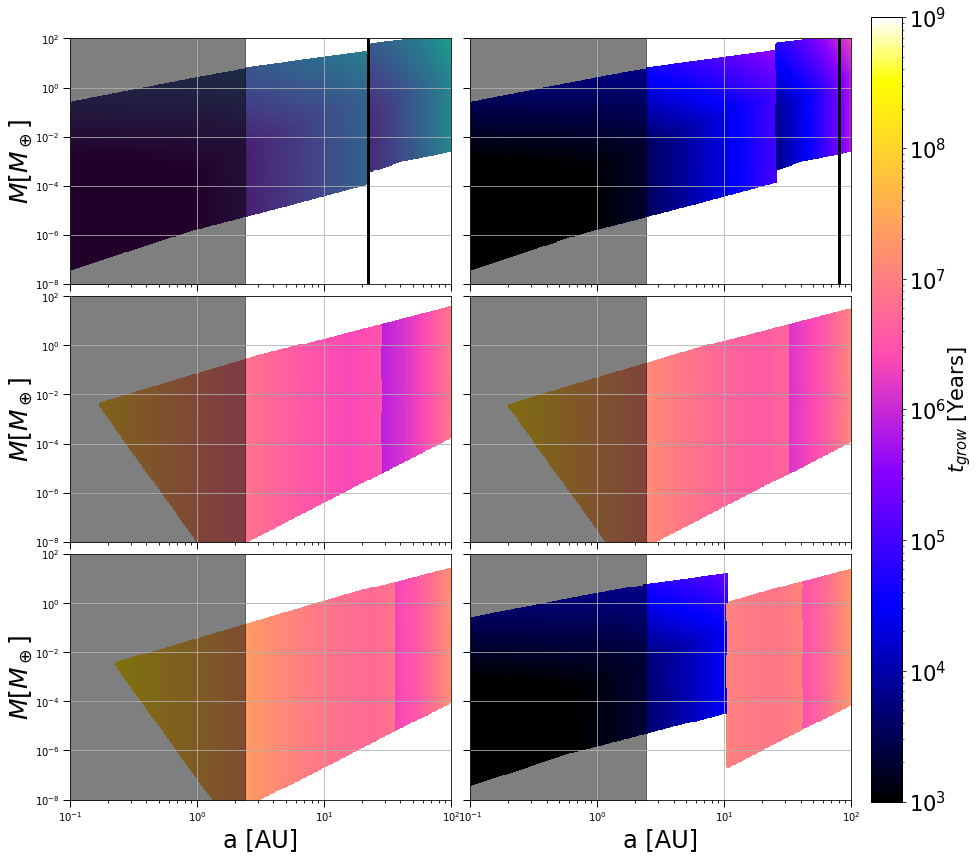

In [39]:
from matplotlib import gridspec
import matplotlib.image as im

# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.05, hspace=0.05)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_VSSG1_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e3,vmax=1e9)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e-1, 1e2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)